In [1]:
# Standard library imports
import os
import math
import argparse
from PIL import Image

# Third-party libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.stats import entropy
import yaml
import easydict

# Custom or local imports
import utils
from datasets import load_from_disk

In [2]:
random_seed = 108
torch.manual_seed(random_seed)

In [3]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)
AVAIL_GPUS,NUM_WORKERS

(1, 32)

In [4]:
data_path = "PreProcessedDataWithEmb4"

In [5]:
reloaded_dataset = load_from_disk(data_path)
reloaded_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'company', 'content', 'description', 'textwithoutcompany', 'fulltext', 'textwithoutcompanycombined', 'fulltext_vector'],
        num_rows: 33034
    })
    test: Dataset({
        features: ['image', 'company', 'content', 'description', 'textwithoutcompany', 'fulltext', 'textwithoutcompanycombined', 'fulltext_vector'],
        num_rows: 14158
    })
})

In [6]:
test_list = ['']

In [7]:
reloaded_dataset["train"] = reloaded_dataset["train"].filter(lambda x: x["company"] == "apple").filter(lambda x: bool([ele for ele in test_list if(ele in x["fulltext"])]))
reloaded_dataset["test"] = reloaded_dataset["test"].filter(lambda x: x["company"] == "apple").filter(lambda x: bool([ele for ele in test_list if(ele in x["fulltext"])]))

In [8]:
reloaded_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'company', 'content', 'description', 'textwithoutcompany', 'fulltext', 'textwithoutcompanycombined', 'fulltext_vector'],
        num_rows: 2341
    })
    test: Dataset({
        features: ['image', 'company', 'content', 'description', 'textwithoutcompany', 'fulltext', 'textwithoutcompanycombined', 'fulltext_vector'],
        num_rows: 951
    })
})

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
torch.cuda.get_device_name(0)

'Quadro RTX 5000'

In [11]:
def get_wrong_image(dataset,correct_class):
        for data in dataset:
            if data['description'] != correct_class:
                return data['image']

In [12]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:
TrainTransformedImage = []
WorngTrainTransformedImage = []
TrainTextVector = []
TrainText = []
for data in reloaded_dataset["train"]:
    image_tensor = transform(data['image'].convert("RGB"))
    wrong_image_tensor = transform(get_wrong_image(reloaded_dataset["train"],data['description']).convert("RGB"))
    TrainTransformedImage.append(image_tensor)
    WorngTrainTransformedImage.append(wrong_image_tensor)
    TrainTextVector.append(np.array(data['fulltext_vector'], dtype="float32"))
    TrainText.append(data["textwithoutcompanycombined"])

In [14]:
transform = transforms.PILToTensor()

TestTransformedImage = []
WorngTestTransformedImage = []
TestTextVector = []
TestText = []
for data in reloaded_dataset["test"]:
    image_tensor = transform(data['image'].convert("RGB"))
    wrong_image_tensor = transform(get_wrong_image(reloaded_dataset["test"],data['company']).convert("RGB"))
    TestTransformedImage.append(image_tensor)
    WorngTestTransformedImage.append(wrong_image_tensor)
    TestTextVector.append(np.array(data['fulltext_vector'], dtype="float32"))
    TestText.append(data["textwithoutcompanycombined"])

In [15]:
from torch.utils.data import Dataset
import numpy as np

class EmojiDataset(Dataset):
    def __init__(self,transformed_image,wrong_transformed_image,text_vector,text):
        self.image_transform = transformed_image
        self.wrong_image_transform = wrong_transformed_image
        self.text_vector = text_vector
        self.text = text
        
    def __len__(self):
        return len(self.image_transform)

    def __getitem__(self, idx):
        image = self.image_transform[idx]
        wrong_image = self.wrong_image_transform[idx]
        fulltext_vector = self.text_vector[idx]
        text = self.text[idx]
        return image, fulltext_vector, wrong_image, text


In [16]:
train_data = EmojiDataset(TrainTransformedImage,WorngTrainTransformedImage,TrainTextVector,TrainText)
test_data = EmojiDataset(TestTransformedImage,WorngTestTransformedImage,TestTextVector,TestText)

In [17]:
sample_args1 = easydict.EasyDict({'type': 'gan',
                        'stage' : 1,
                        'stage1_gen_path': '',
                        'lr': 0.001,
                        'l1_coef': 50,
                        'l2_coef': 100,
                        'noise_dim': 200,
                        'embed_dim': 200,
                        'projected_embed_dim': 2048,
                        'cls': True,
                        'save_path':'Result',
                        'train_data': train_data,
                        'test_data': test_data,
                        'batch_size': 128,
                        'ngf': 64,
                        'ndf': 64,
                        'num_workers':7,
                        'image_size': 64,
                        'num_channels': 3,
                        'epochs': 1000})

sample_args2 = easydict.EasyDict({'type': 'gan',
                        'stage' : 2,
                        'stage1_gen_path': '/home/emoji_with_text/results-20240921-133704/200/gen.pth',
                        'lr': 0.0007,
                        'l1_coef': 50,
                        'l2_coef': 100,
                        'noise_dim': 200,
                        'embed_dim': 200,
                        'projected_embed_dim': 2048,
                        'cls': True,
                        'save_path':'Result',
                        'train_data': train_data,
                        'test_data': test_data,
                        'batch_size': 64,
                        'ngf': 64,
                        'ndf': 64,
                        'num_workers':7,
                        'image_size': 64,
                        'num_channels': 3,
                        'epochs': 200})

In [18]:
class Utils(object):
    
    @staticmethod
    def smooth_label(tensor, offset):
        return tensor + offset
    
    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    @staticmethod
    def save_checkpoint(netD, netG, dir_path, subdir_path, epoch):
        path =  subdir_path
        if not os.path.exists(path):
            os.makedirs(path)

        torch.save(netD.state_dict(), '{0}/{1}/disc.pth'.format(path, epoch))
        torch.save(netG.state_dict(), '{0}/{1}/gen.pth'.format(path, epoch))


In [19]:
class generator(nn.Module):
    def __init__(self,args):
        super(generator, self).__init__()
        
        self.args = args
        self.image_size = args.image_size
        self.num_channels = args.num_channels
        self.noise_dim = args.noise_dim
        self.embed_dim = args.embed_dim
        self.projected_embed_dim = args.projected_embed_dim
        self.latent_dim = self.noise_dim + (self.projected_embed_dim * 2)
        self.ngf = args.ngf
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=self.projected_embed_dim, out_features=self.projected_embed_dim*2),
            nn.BatchNorm1d(num_features=self.projected_embed_dim*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, self.ngf * 16, 2, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 16, self.ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2,self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
             # state size. (num_channels) x 64 x 64
            )


    def forward(self, embed_vector, z):

        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        latent_vector = torch.cat([projected_embed, z], 1)
        output = self.netG(latent_vector)

        return output

In [20]:
netG = generator(sample_args1).to(device)
# Handle multi-gpu if desired
netG.apply(Utils.weights_init)
# Print the model
print(netG)

generator(
  (projection): Sequential(
    (0): Linear(in_features=200, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=2048, out_features=4096, bias=True)
    (4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (netG): Sequential(
    (0): ConvTranspose2d(4296, 1024, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm

In [21]:
from torchinfo import summary
input_data = ((netG.args.batch_size,netG.args.embed_dim),(netG.args.batch_size,netG.args.noise_dim,1,1))

summary(netG,input_size=input_data)

Layer (type:depth-idx)                   Output Shape              Param #
generator                                [128, 3, 64, 64]          --
├─Sequential: 1-1                        [128, 4096]               --
│    └─Linear: 2-1                       [128, 2048]               411,648
│    └─BatchNorm1d: 2-2                  [128, 2048]               4,096
│    └─LeakyReLU: 2-3                    [128, 2048]               --
│    └─Linear: 2-4                       [128, 4096]               8,392,704
│    └─BatchNorm1d: 2-5                  [128, 4096]               8,192
│    └─LeakyReLU: 2-6                    [128, 4096]               --
├─Sequential: 1-2                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-7              [128, 1024, 2, 2]         17,596,416
│    └─BatchNorm2d: 2-8                  [128, 1024, 2, 2]         2,048
│    └─ReLU: 2-9                         [128, 1024, 2, 2]         --
│    └─ConvTranspose2d: 2-10             [128, 512, 4, 4

In [22]:
class generator2(nn.Module):
    def __init__(self,stage1_gen,args):
        super(generator2, self).__init__()
        
        self.args = args
        self.image_size = args.image_size
        self.num_channels = args.num_channels
        self.noise_dim = args.noise_dim
        self.embed_dim = args.embed_dim
        self.projected_embed_dim = args.projected_embed_dim
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.stage2_latent_dim = self.image_size*self.image_size*self.num_channels + self.noise_dim + self.projected_embed_dim
        self.ngf = args.ngf
        
        self.stage1_gen = stage1_gen
        # Freezing the stage 1 generator:
        for param in self.stage1_gen.parameters():
            param.requires_grad = False
            
            
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(3, 128, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), #? Paper: leaky, code: relu
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.projected_embed_dim+512, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(256,128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(64, self.num_channels, 3, 1, 1, bias=False),
            nn.Tanh()
             # state size. (num_channels) x 64 x 64
            )
            


    def forward(self, embed_vector, noise):
        
        stage1_img = self.stage1_gen(embed_vector, noise)
        stage1_img = stage1_img.detach()
        
        #(batch_size,512,16,16)
        encoded_img = self.encoder(stage1_img)
        
        #(batch_size,128,16,16)
        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3).repeat(1, 1, 16, 16)
        
        #(batch_size,512,16,16)
        latent_vector = torch.cat([encoded_img,projected_embed], 1)
        
        #(batch_size,3,64,64)
        output = self.netG(latent_vector)

        return output

In [23]:
netG2 = generator2(netG,sample_args2)
# Handle multi-gpu if desired
netG2.apply(Utils.weights_init)
# Print the model
print(netG2)

generator2(
  (stage1_gen): generator(
    (projection): Sequential(
      (0): Linear(in_features=200, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Linear(in_features=2048, out_features=4096, bias=True)
      (4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (netG): Sequential(
      (0): ConvTranspose2d(4296, 1024, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), s

In [24]:
from torchinfo import summary
input_data = ((netG.args.batch_size,netG.args.embed_dim),(netG.args.batch_size,netG.args.noise_dim,1,1))

summary(netG2,input_size=input_data)

Layer (type:depth-idx)                   Output Shape              Param #
generator2                               [128, 3, 64, 64]          --
├─generator: 1-1                         [128, 3, 64, 64]          --
│    └─Sequential: 2-1                   [128, 4096]               --
│    │    └─Linear: 3-1                  [128, 2048]               (411,648)
│    │    └─BatchNorm1d: 3-2             [128, 2048]               (4,096)
│    │    └─LeakyReLU: 3-3               [128, 2048]               --
│    │    └─Linear: 3-4                  [128, 4096]               (8,392,704)
│    │    └─BatchNorm1d: 3-5             [128, 4096]               (8,192)
│    │    └─LeakyReLU: 3-6               [128, 4096]               --
│    └─Sequential: 2-2                   [128, 3, 64, 64]          --
│    │    └─ConvTranspose2d: 3-7         [128, 1024, 2, 2]         (17,596,416)
│    │    └─BatchNorm2d: 3-8             [128, 1024, 2, 2]         (2,048)
│    │    └─ReLU: 3-9                    [12

In [25]:
class discriminator(nn.Module):
    def __init__(self,args):
        super(discriminator, self).__init__()
        
        self.args = args
        self.image_size = args.image_size
        self.num_channels = args.num_channels
        self.embed_dim = args.embed_dim
        self.projected_embed_dim = args.projected_embed_dim
        self.ndf = args.ndf
        #self.B_dim = 128
        #self.C_dim = 16

        self.netD_1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.projector = utils.Concat_embed(self.embed_dim, self.projected_embed_dim)

        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            )

    def forward(self, inp, embed):
        x_intermediate = self.netD_1(inp)
        x = self.projector(x_intermediate, embed)
        x = self.netD_2(x)

        return x.view(-1, 1).squeeze(1) , x_intermediate

In [26]:
netD_1 = discriminator(sample_args1).to(device)
# Handle multi-gpu if desired
netD_1.apply(Utils.weights_init)
# Print the model
print(netD_1)

discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (projector): Concat_embed(
    (projection): Sequential(
      (0): Linear(in_features=200, out_features=2048, bias=True

In [27]:
from torchinfo import summary
input_data = ((netD_1.args.batch_size,3,64,64),(netD_1.args.batch_size, netD_1.args.embed_dim))

summary(netD_1,input_size=input_data)

Layer (type:depth-idx)                   Output Shape              Param #
discriminator                            [128]                     --
├─Sequential: 1-1                        [128, 512, 4, 4]          --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         3,072
│    └─LeakyReLU: 2-2                    [128, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-4                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-5                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-6                       [128, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-7                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-8                    [128, 256, 8, 8]          --
│    └─Conv2d: 2-9                       [128, 512, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-10                 [128, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-11                   [128, 512, 4, 4]   

In [28]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

20241010-133752


In [29]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for Inception
])

In [30]:
def inception_score(images, inception_model,args, splits=10):
    """Computes the Inception Score (IS)"""
    N = len(images)
        
    splits = int(args.batch_size/2)
    newimages = []
    for image in images:
        newimages.append(transform(image))
    
    dataloader = DataLoader(newimages, batch_size=args.batch_size)

    def get_preds(x):
        with torch.no_grad():
            preds = inception_model(x)
        return F.softmax(preds, dim=1).cpu().numpy()

    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader):
        preds[i * 32 : i * 32 + len(batch)] = get_preds(batch.cuda())

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            scores.append(entropy(part[i], py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [31]:
def calculate_fid(real_features, gen_features):
    """Computes the Frechet Inception Distance (FID)"""
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)
    diff = mu1 - mu2
    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def get_inception_features(dataloader, model):
    """Extract features using a pretrained Inception model"""
    features = []
    for batch in dataloader:
        with torch.no_grad():
            batch = batch.cuda()  # Use only images, not labels
            preds = model(batch)
        features.append(preds.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

In [32]:
def fid_score(real_dataset, gen_dataset, model, args):
    # Dataloaders
    
    real_dataset_transform = []
    for image in real_dataset:
        real_dataset_transform.append(transform(image))
        
    gen_dataset_transform = []
    for image in gen_dataset:
        gen_dataset_transform.append(transform(image))
        
    real_dataloader = DataLoader(real_dataset_transform, batch_size=args.batch_size, shuffle=False)
    gen_dataloader = DataLoader(gen_dataset_transform, batch_size=args.batch_size, shuffle=False)

    # Get Inception features
    real_features = get_inception_features(real_dataloader, model)
    gen_features = get_inception_features(gen_dataloader, model)
    
    fid_value = calculate_fid(real_features, gen_features)
    return fid_value

In [33]:
ssim_transform = transforms.Compose([
    transforms.ToTensor()
])

# Convert image to grayscale, apply to both input images for SSIM calculation
def to_grayscale(img):
    gray_transform = transforms.Grayscale(num_output_channels=1)
    return gray_transform(img)

def ssim(img1, img2, window_size=11, size_average=True):
    """Compute SSIM between two images."""
    
    '''img1_transform = []
    for image in img1:
        img1_transform.append(ssim_transform(image))
        
    img2_transform = []
    for image in img2:
        img2_transform.append(ssim_transform(image))'''
    
    # Define Gaussian window for structural similarity calculation
    def gaussian(window_size, sigma):
        """Create a 1D Gaussian kernel using PyTorch tensors."""
        x_values = torch.arange(-window_size // 2 + 1, window_size // 2 + 1, dtype=torch.float32)
        gauss = (1 / (sigma * torch.sqrt(2.0 * torch.tensor(torch.pi)))) * torch.exp(-(x_values**2) / (2 * sigma**2))
        return gauss / gauss.sum()

    def create_window(window_size, channel):
        """Create a 2D Gaussian window."""
        _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    # Ensure both images have the same shape
    (_, channel, height, width) = img1.size()
    window = create_window(window_size, channel).cuda()

    # Define constants to stabilize division with weak denominators
    C1 = 0.01**2
    C2 = 0.03**2

    # Compute means
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    # Compute variances
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    # SSIM calculation
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

In [34]:
# Load pretrained Inception v3 model for Inception Score
inception_model = models.inception_v3(pretrained=True, transform_input=False).eval().cuda()

In [35]:
class Logger(object):
    def __init__(self):
        self.data = {
            "epoch": [],
            "d_loss":[],
            "g_loss":[],
            "real_score":[],
            "fake_score":[],
            "fretchet_dist":[],
            "mean_score":[],
            "std_score":[],
            "ssim_value":[],
        }
    
    def log_iteration_gan(self, epoch, iteration, d_loss, g_loss, real_score, fake_score,fretchet_dist=0, mean_score=0, std_score=0, ssim_value=0):
        self.data["epoch"].append(epoch)
        self.data["d_loss"].append(d_loss.data.cpu().mean())
        self.data["g_loss"].append(g_loss.data.cpu().mean())
        self.data["real_score"].append(real_score.data.cpu().mean())
        self.data["fake_score"].append(fake_score.data.cpu().mean())  
        self.data["fretchet_dist"].append(fretchet_dist)
        self.data["mean_score"].append(mean_score)
        self.data["std_score"].append(std_score)
        self.data["ssim_value"].append(ssim_value)
        if(epoch%10 == 0):
            print("Epoch: %d, Iter: %d, d_loss= %f, g_loss= %f, D(X)= %f, D(G(X))= %f, fretchet_dist=%f, Inception Score=%s, ssim_value=%f" % (
                epoch, iteration, d_loss.data.cpu().mean(), g_loss.data.cpu().mean(), real_score.data.cpu().mean(),
                fake_score.data.cpu().mean(),fretchet_dist,str(mean_score)+"±"+str(std_score),ssim_value))
        
    def log_prediction_gan(self, fretchet_dist=0, mean_score=0, std_score=0, ssim_value=0): 
        self.data["fretchet_dist"].append(fretchet_dist)
        self.data["mean_score"].append(mean_score)
        self.data["std_score"].append(std_score)
        self.data["ssim_value"].append(ssim_value)
        print("fretchet_dist=%f, Inception Score=%s, ssim_value=%f" % (
            fretchet_dist,str(mean_score)+"±"+str(std_score),ssim_value))
        
    def get_log_dataframe(self):
        return pd.DataFrame(self.data)

In [36]:
class Trainer(object):
    def __init__(self,parameter):
        self.args = parameter
        
        if parameter.stage == 1 :
            self.generator = torch.nn.DataParallel(generator(parameter).cuda())
            self.discriminator = torch.nn.DataParallel(discriminator(parameter).cuda())
        else:
            self.stage1_generator = torch.nn.DataParallel(generator(parameter).cuda())
            self.generator = torch.nn.DataParallel(generator2(self.stage1_generator,parameter).cuda())
            self.discriminator = torch.nn.DataParallel(discriminator(parameter).cuda())
        
            if parameter.stage1_gen_path != "":
                self.stage1_generator.load_state_dict(torch.load(parameter.stage1_gen_path))
                print("Generator 1 loaded from: ", parameter.stage1_gen_path)
            else:
                print("Please give the Stage 1 generator path")
                return
        
        self.discriminator.apply(Utils.weights_init)
        self.generator.apply(Utils.weights_init)

        self.test_data = parameter.test_data
        self.train_data = parameter.train_data

        self.noise_dim = parameter.noise_dim
        self.batch_size = parameter.batch_size
        self.num_workers = parameter.num_workers
        self.lr = parameter.lr
        self.beta1 = 0.5
        self.num_epochs = parameter.epochs


        self.l1_coef = parameter.l1_coef
        self.l2_coef = parameter.l2_coef

        self.train_data_loader = DataLoader(self.train_data, batch_size=self.batch_size, drop_last=True, shuffle=True, num_workers=self.num_workers)
        self.test_data_loader = DataLoader(self.test_data, batch_size=self.batch_size, drop_last=True, shuffle=True, num_workers=self.num_workers)

        self.optimD = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))
        self.optimG = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))

        self.train_logger = Logger()
        self.test_logger = Logger()
        
        self.checkpoints_path = 'checkpoints'
        self.save_path = parameter.save_path
        self.type = parameter.type
        
        self.train_max_iter= math.ceil(len(TrainText)/self.batch_size)

    def train(self):
        criterion = nn.BCELoss()
        l2_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()
        
        for epoch in range(1,self.num_epochs+1):
            iteration = 1
            mean_score_list = []
            fretchet_dist_list = []
            ssim_value_list = []
            std_score_list = []
            for sample in self.train_data_loader:
                iteration += 1
                
                right_images = Variable(sample[0].float()).cuda()
                right_embed = Variable(sample[1].float()).cuda()
                wrong_images = Variable(sample[2].float()).cuda()
                
                text = sample[3]

                real_labels = torch.ones(right_images.size(0))
                fake_labels = torch.zeros(right_images.size(0))

                smoothed_real_labels = torch.FloatTensor(Utils.smooth_label(real_labels.numpy(), -0.1))
                smoothed_real_labels = Variable(smoothed_real_labels).cuda()
                
                real_labels = Variable(real_labels).cuda()
                fake_labels = Variable(fake_labels).cuda()

                # Train the discriminator
                self.discriminator.zero_grad()
                real_score, activation_real = self.discriminator(right_images, right_embed)
                real_loss = criterion(real_score, smoothed_real_labels)

                wrong_score, _ = self.discriminator(wrong_images, right_embed)
                wrong_loss = criterion(wrong_score, fake_labels)

                noise = Variable(torch.randn(right_images.size(0), self.noise_dim)).cuda()
                noise = noise.view(noise.size(0), self.noise_dim, 1, 1)
                
                fake_images = self.generator(right_embed, noise)
                
                fake_score, activation_fake = self.discriminator(fake_images, right_embed)
                fake_loss = criterion(fake_score, fake_labels)

                d_loss = real_loss + fake_loss

                d_loss = d_loss + wrong_loss

                d_loss.backward()
                self.optimD.step()

                # Train the generator
                self.generator.zero_grad()
                
                noise = Variable(torch.randn(right_images.size(0), self.noise_dim)).cuda()
                noise = noise.view(noise.size(0), self.noise_dim, 1, 1)
                
                fake_images = self.generator(right_embed, noise)
                outputs, activation_fake = self.discriminator(fake_images, right_embed)
                _, activation_real = self.discriminator(right_images, right_embed)
                
                activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
                activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

                g_loss = criterion(outputs, real_labels) + self.l2_coef * l2_loss(activation_fake, activation_real.detach()) + self.l1_coef * l1_loss(fake_images, right_images)

                g_loss.backward()
                self.optimG.step()
                
                if iteration==self.train_max_iter and (epoch % 10 == 0 or epoch == 1):
                    if not os.path.exists('results-{0}/{1}/{2}'.format(timestr,self.save_path,epoch)):
                        os.makedirs('results-{0}/{1}/{2}'.format(timestr,self.save_path,epoch))
                    '''for image, t in zip(fake_images, text):
                        im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                        im.save('results-{0}/{2}/{1}.jpg'.format(timestr,t,epoch))'''
                    vutils.save_image(fake_images, os.path.join('results-{0}/{1}/{2}'.format(timestr,self.save_path,epoch), "generated.png"), normalize=True)
                    vutils.save_image(right_images, os.path.join('results-{0}/{1}/{2}'.format(timestr,self.save_path,epoch), "real.png"), normalize=True)
            
            if epoch%10 == 0 or epoch == 1:
                mean_score, std_score = inception_score(fake_images, inception_model,self.args)
                fretchet_dist=fid_score(right_images,fake_images,inception_model,self.args) 
                ssim_value = ssim(right_images, fake_images)

                mean_score_list.append(mean_score)
                std_score_list.append(std_score)
                fretchet_dist_list.append(fretchet_dist)
                ssim_value_list.append(ssim_value.cpu().detach().numpy())
                
                self.train_logger.log_iteration_gan(epoch, iteration, d_loss, g_loss, real_score, fake_score,np.mean(fretchet_dist_list),np.mean(mean_score_list),np.mean(std_score_list),np.mean(ssim_value_list))
            
                #Utils.save_checkpoint(self.discriminator, self.generator, self.checkpoints_path, 'results-{0}/{1}'.format(timestr,self.save_path), epoch)
            if epoch%100 == 0:
                Utils.save_checkpoint(self.discriminator, self.generator, self.checkpoints_path, 'results-{0}/{1}'.format(timestr,self.save_path), epoch)
    
    def predict(self):
        iteration = 1
        mean_score_list = []
        fretchet_dist_list = []
        ssim_value_list = []
        std_score_list = []
        for sample in self.test_data_loader:
            #print len(sample)
            right_images = Variable(sample[0].float()).cuda()
            right_embed = Variable(sample[1].float()).cuda()
            wrong_images = Variable(sample[2].float()).cuda()
            text = sample[3]
            #print type(right_embed)
            #print right_embed.shape
            #break
            #txt = sample['txt']

            if not os.path.exists('results-{0}/{1}/predict'.format(timestr,self.save_path)):
                os.makedirs('results-{0}/{1}/predict'.format(timestr,self.save_path))

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()

            # Train the generator
            noise = Variable(torch.randn(self.batch_size, self.noise_dim)).cuda()
            noise = noise.view(self.batch_size, self.noise_dim, 1, 1)
            fake_images = self.generator(right_embed, noise)
            vutils.save_image(fake_images, 'results-{0}/{1}/predict/{2}-prediction.png'.format(timestr,self.save_path,iteration), normalize=True)
            vutils.save_image(right_images, 'results-{0}/{1}/predict/{2}-real.png'.format(timestr,self.save_path,iteration), normalize=True)
            iteration = iteration + 1
            '''for image, t in zip(fake_images,text):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                im.save('results-{0}/predict/{1}.jpg'.format(timestr, t))'''
        
        mean_score, std_score = inception_score(fake_images, inception_model,self.args)
        fretchet_dist=fid_score(right_images,fake_images,inception_model,self.args) 
        ssim_value = ssim(right_images, fake_images)

        mean_score_list.append(mean_score)
        std_score_list.append(std_score)
        fretchet_dist_list.append(fretchet_dist)
        ssim_value_list.append(ssim_value.cpu().detach().numpy())
            
        self.test_logger.log_prediction_gan(np.mean(fretchet_dist_list),np.mean(mean_score_list),np.mean(std_score_list),np.mean(ssim_value_list))
            
    
    def save_parameters(self):
        self.args.pop('train_data', None)
        self.args.pop('test_data', None)

        import json
        path = 'results-{0}/{1}'.format(timestr,self.save_path)

        if not os.path.exists(path):
            os.makedirs(path)

        with open(os.path.join(path,'data.json'), 'w', encoding='utf-8') as f:
            json.dump(self.args, f, ensure_ascii=False, indent=4)
    
    def save_plot_graph(self):
        path = 'results-{0}/{1}/train_log.csv'.format(timestr,self.save_path)
        self.train_logger.get_log_dataframe().to_csv(path, sep='\t', encoding='utf-8', index=False, header=True)

        # Create the figure and axes
        fig, axs = plt.subplots(4, 2, figsize=(12, 8))

        # Plot D Loss
        axs[0, 0].plot(self.train_logger.get_log_dataframe()["d_loss"])
        axs[0, 0].set_title("Discriminator Loss")
        axs[0, 0].set_xlabel("Epoch")
        axs[0, 0].set_ylabel("Loss")

        # Plot G Loss
        axs[0, 1].plot(self.train_logger.get_log_dataframe()["g_loss"])
        axs[0, 1].set_title("Generator Loss")
        axs[0, 1].set_xlabel("Epoch")
        axs[0, 1].set_ylabel("Loss")

        # Plot D(X)real_score
        axs[1, 0].plot(self.train_logger.get_log_dataframe()["real_score"])
        axs[1, 0].set_title("Discriminator Output for Real Images (D(X))")
        axs[1, 0].set_xlabel("Epoch")
        axs[1, 0].set_ylabel("Score")

        # Plot D(G(X))fake_score
        axs[1, 1].plot(self.train_logger.get_log_dataframe()["fake_score"])
        axs[1, 1].set_title("Discriminator Output for Fake Images (D(G(X)))")
        axs[1, 1].set_xlabel("Epoch")
        axs[1, 1].set_ylabel("Score")

        # Plot fid_metric
        axs[2, 0].plot(self.train_logger.get_log_dataframe()["fretchet_dist"])
        axs[2, 0].set_title("fretchet_dist")
        axs[2, 0].set_xlabel("Epoch")
        axs[2, 0].set_ylabel("Fretchet Score")

        # Plot fid_metric
        axs[2, 1].plot(self.train_logger.get_log_dataframe()["mean_score"])
        #axs[2, 1].plot(self.train_logger.get_log_dataframe()["mean_score"]+self.train_logger.get_log_dataframe()["std_score"])
        #axs[2, 1].plot(self.train_logger.get_log_dataframe()["mean_score"]-self.train_logger.get_log_dataframe()["std_score"])
        axs[2, 1].set_title("Insception Score")
        axs[2, 1].set_xlabel("Epoch")
        axs[2, 1].set_ylabel("Insception Mean")

        # Plot fid_metric
        axs[3, 0].plot(self.train_logger.get_log_dataframe()["ssim_value"])
        axs[3, 0].set_title("Structural Similarity Index")
        axs[3, 0].set_xlabel("Epoch")
        axs[3, 0].set_ylabel("SSIM Value")

        # Adjust layout and display the plot
        plt.tight_layout()

        path = 'results-{0}/{1}/plot.jpg'.format(timestr,self.save_path)

        plt.savefig(path)
        plt.show()

In [39]:
import itertools
hyperparameters = {
    'lr': [0.0005],
    'noise_dim': [200],
    'projected_embed_dim': [2048],
    'batch_size': [64],
}

base_args1 = easydict.EasyDict({'type': 'gan',
                        'stage' : 1,
                        'stage1_gen_path': '',
                        'lr': 0.0005,
                        'l1_coef': 50,
                        'l2_coef': 100,
                        'noise_dim': 200,
                        'embed_dim': 200,
                        'projected_embed_dim': 2048,
                        'cls': True,
                        'save_path':'Result',
                        'train_data': train_data,
                        'test_data': test_data,
                        'batch_size': 128,
                        'ngf': 64,
                        'ndf': 64,
                        'num_workers':7,
                        'image_size': 64,
                        'num_channels': 3,
                        'epochs': 1000,
                        'config':()})

args_list = []

iterartion = 1
for l in itertools.product(*hyperparameters.values()):
    args = base_args1.copy()
    args['config'] = l
    args['lr'] = l[0]
    args['noise_dim'] = l[1]
    args['projected_embed_dim'] = l[2]
    args['batch_size'] = l[3]
    args['save_path'] = args['save_path']+ str(iterartion)
    args_list.append(easydict.EasyDict(args))
    iterartion = iterartion + 1 

len(args_list)

1

Result1 (0.0005, 200, 2048, 64)
----------------------------------------------------------------------------------------------------
Epoch: 10, Iter: 37, d_loss= 1.657338, g_loss= 3869.909912, D(X)= 0.966154, D(G(X))= 0.644878, fretchet_dist=1312.571368, Inception Score=1.383118076990426±0.1718818537738552, ssim_value=0.138508
Epoch: 20, Iter: 37, d_loss= 1.917444, g_loss= 3622.078125, D(X)= 0.166120, D(G(X))= 0.025586, fretchet_dist=1305.666095, Inception Score=1.3821929792222662±0.13946688163526905, ssim_value=0.154996
Epoch: 30, Iter: 37, d_loss= 0.718036, g_loss= 3843.890381, D(X)= 0.610239, D(G(X))= 0.082170, fretchet_dist=1447.058078, Inception Score=1.5151132232393543±0.16348189861884282, ssim_value=0.136752
Epoch: 40, Iter: 37, d_loss= 1.362098, g_loss= 3850.056885, D(X)= 0.329155, D(G(X))= 0.093884, fretchet_dist=1535.813749, Inception Score=1.4692994355154199±0.16491505598121514, ssim_value=0.155311
Epoch: 50, Iter: 37, d_loss= 1.855056, g_loss= 3718.233154, D(X)= 0.958815, D

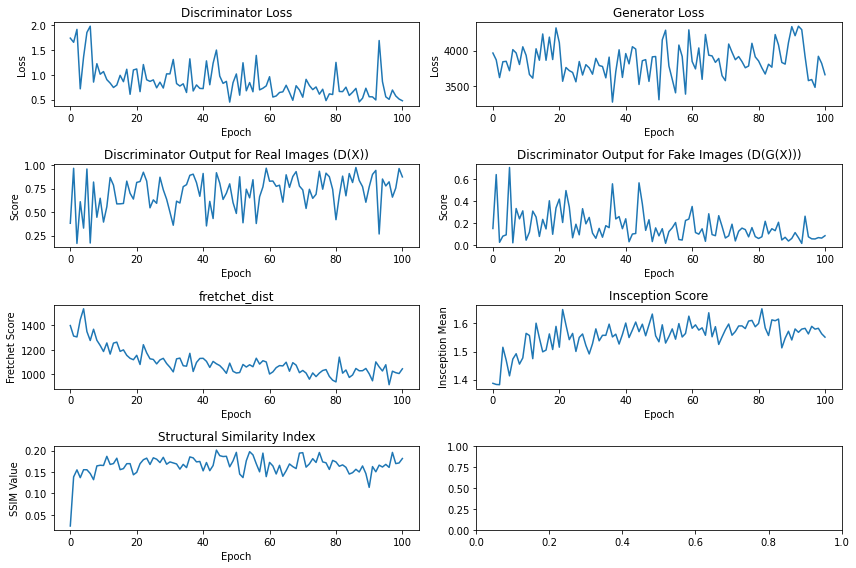

      name                   config  fretchet_dist  mean_score  std_score  \
0  Result1  (0.0005, 200, 2048, 64)    1132.129262    1.539042   0.159048   

   ssim_value  
0     0.16287  


In [40]:
import sys

data = {
    'name':[],
    'config':[],
    "fretchet_dist":[],
    "mean_score":[],
    "std_score":[],
    "ssim_value":[],
}
for args in args_list:
    print(args.save_path,args.config)
    print("-"*100)
    trainer = Trainer(args)
    trainer.train()
    trainer.predict()
    trainer.save_parameters()
    trainer.save_plot_graph()
    data["name"].append(args.save_path)
    data["config"].append(args.config)
    data["fretchet_dist"].append(trainer.test_logger.data["fretchet_dist"][0])
    data["mean_score"].append(trainer.test_logger.data["mean_score"][0])
    data["std_score"].append(trainer.test_logger.data["std_score"][0])
    data["ssim_value"].append(trainer.test_logger.data["ssim_value"][0])
    print(pd.DataFrame(data))

In [41]:
path = 'hyperparameter1.pkl'
pd.DataFrame(data).to_pickle(path)

In [42]:
df = pd.read_pickle(path)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1 non-null      object 
 1   config         1 non-null      object 
 2   fretchet_dist  1 non-null      float64
 3   mean_score     1 non-null      float64
 4   std_score      1 non-null      float64
 5   ssim_value     1 non-null      float32
dtypes: float32(1), float64(3), object(2)
memory usage: 172.0+ bytes


In [44]:
df.describe()

,fretchet_dist,mean_score,std_score,ssim_value
count,1.000000,1.000000,1.000000,1.00000
mean,1132.129262,1.539042,0.159048,0.16287
std,NaN,NaN,NaN,NaN
min,1132.129262,1.539042,0.159048,0.16287
25%,1132.129262,1.539042,0.159048,0.16287
50%,1132.129262,1.539042,0.159048,0.16287
75%,1132.129262,1.539042,0.159048,0.16287
max,1132.129262,1.539042,0.159048,0.16287


In [46]:
df

,name,config,fretchet_dist,mean_score,std_score,ssim_value,lr,embd_dim,proj_embd_dim,batch_size
0,Result1,"(0.0005, 200, 2048, 64)",1132.129262,1.539042,0.159048,0.16287,0.0005,200,2048,64


In [45]:
df['lr'] = df['config'].apply(lambda x: x[0])
df['embd_dim'] = df['config'].apply(lambda x: x[1])
df['proj_embd_dim'] = df['config'].apply(lambda x: x[2])
df['batch_size'] = df['config'].apply(lambda x: x[3])

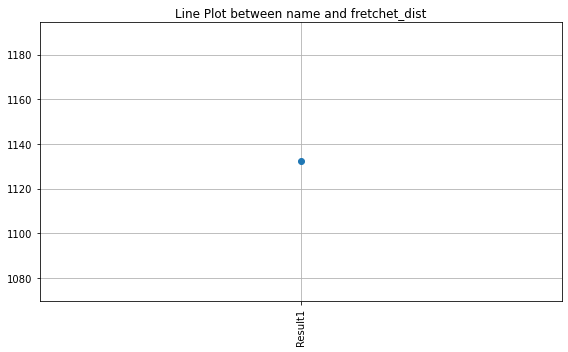

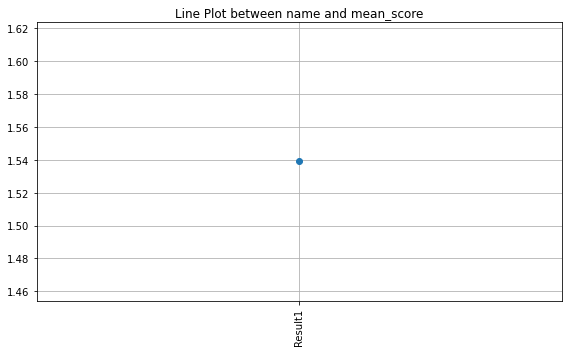

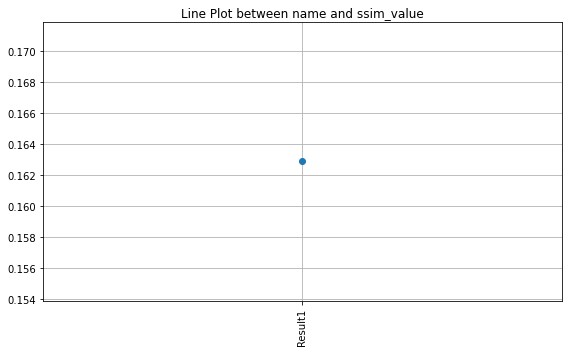

In [48]:
list1=['lr','embd_dim','proj_embd_dim','batch_size']
list2=['fretchet_dist','mean_score','ssim_value']

import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
tempdf = df

# Assuming you have a pandas dataframe 'df'
# Create a list of all column names
columns = tempdf.columns

# Generate all possible pairs of columns
column_pairs = list(combinations(columns, 2))

# Plot line graph for each pair
for col in list2:
    plt.figure(figsize=(8, 5))
    plt.plot(tempdf['name'], tempdf[col], marker='o')
    plt.title(f'Line Plot between name and {col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [37]:
import itertools
hyperparameters = {
    'lr': [0.0005],
    'noise_dim': [200],
    'projected_embed_dim': [2048],
    'batch_size': [64],
}

base_args1 = easydict.EasyDict({'type': 'gan',
                        'stage' : 2,
                        'stage1_gen_path': 'results-20241010-113409/Result1/1000/gen.pth',
                        'lr': 0.001,
                        'l1_coef': 50,
                        'l2_coef': 100,
                        'noise_dim': 200,
                        'embed_dim': 200,
                        'projected_embed_dim': 2048,
                        'cls': True,
                        'save_path':'Result',
                        'train_data': train_data,
                        'test_data': test_data,
                        'batch_size': 128,
                        'ngf': 64,
                        'ndf': 64,
                        'num_workers':7,
                        'image_size': 64,
                        'num_channels': 3,
                        'epochs': 1000,
                        'config':()})

args_list = []

iterartion = 1
for l in itertools.product(*hyperparameters.values()):
    args = base_args1.copy()
    args['config'] = l
    args['lr'] = l[0]
    args['noise_dim'] = l[1]
    args['projected_embed_dim'] = l[2]
    args['batch_size'] = l[3]
    args['save_path'] = args['save_path']+ str(iterartion)
    args_list.append(easydict.EasyDict(args))
    iterartion = iterartion + 1 

len(args_list)

1

In [38]:
import sys

data = {
    'name':[],
    'config':[],
    "fretchet_dist":[],
    "mean_score":[],
    "std_score":[],
    "ssim_value":[],
}
for args in args_list:
    print(args.save_path,args.config)
    print("-"*100)
    trainer = Trainer(args)
    trainer.train()
    trainer.predict()
    trainer.save_parameters()
    trainer.save_plot_graph()
    data["name"].append(args.save_path)
    data["config"].append(args.config)
    data["fretchet_dist"].append(trainer.test_logger.data["fretchet_dist"][0])
    data["mean_score"].append(trainer.test_logger.data["mean_score"][0])
    data["std_score"].append(trainer.test_logger.data["std_score"][0])
    data["ssim_value"].append(trainer.test_logger.data["ssim_value"][0])
    print(pd.DataFrame(data))

Result1 (0.0005, 200, 2048, 64)
----------------------------------------------------------------------------------------------------
Generator 1 loaded from:  results-20241010-113409/Result1/1000/gen.pth
Epoch: 10, Iter: 37, d_loss= 0.654711, g_loss= 3977.584229, D(X)= 0.693567, D(G(X))= 0.053997, fretchet_dist=1341.498030, Inception Score=1.4345640946719989±0.1710033132207844, ssim_value=0.079734
Epoch: 20, Iter: 37, d_loss= 1.819625, g_loss= 3930.919189, D(X)= 0.213003, D(G(X))= 0.005098, fretchet_dist=1420.068453, Inception Score=1.4860909967068852±0.1621899164694672, ssim_value=0.102436
Epoch: 30, Iter: 37, d_loss= 0.599123, g_loss= 4101.914551, D(X)= 0.859678, D(G(X))= 0.141339, fretchet_dist=1380.724306, Inception Score=1.4340884294434644±0.16829422508386774, ssim_value=0.121877
Epoch: 40, Iter: 37, d_loss= 0.464103, g_loss= 3648.236816, D(X)= 0.837772, D(G(X))= 0.052789, fretchet_dist=1412.836350, Inception Score=1.3967800726331923±0.1541463908585995, ssim_value=0.117967
Epoch: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f984919dc10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1337, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1310, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

fretchet_dist=1205.413930, Inception Score=1.5074272193203089±0.17995582987531503, ssim_value=0.148699


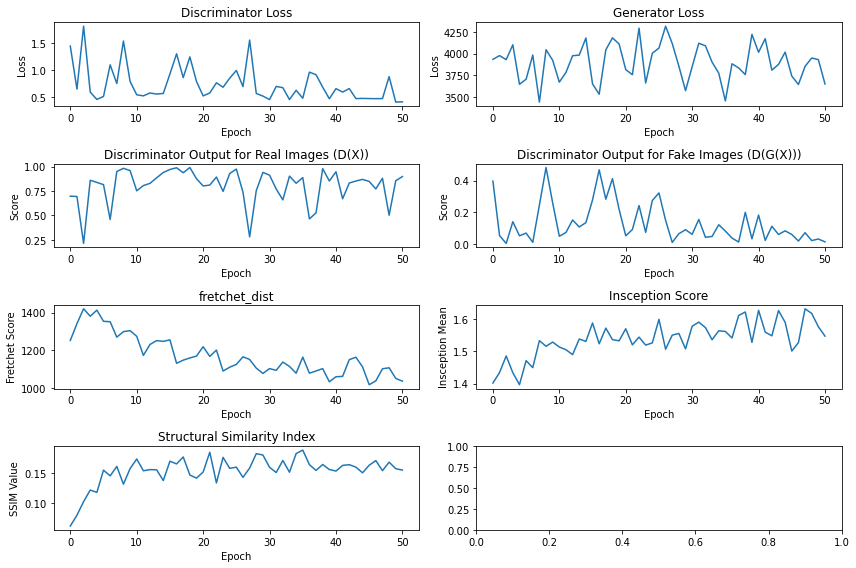

      name                   config  fretchet_dist  mean_score  std_score  \
0  Result1  (0.0005, 200, 2048, 64)     1205.41393    1.507427   0.179956   

   ssim_value  
0    0.148699  


In [39]:
trainer.predict()
trainer.save_parameters()
trainer.save_plot_graph()
data["name"].append(args.save_path)
data["config"].append(args.config)
data["fretchet_dist"].append(trainer.test_logger.data["fretchet_dist"][0])
data["mean_score"].append(trainer.test_logger.data["mean_score"][0])
data["std_score"].append(trainer.test_logger.data["std_score"][0])
data["ssim_value"].append(trainer.test_logger.data["ssim_value"][0])
print(pd.DataFrame(data))

In [40]:
path = 'hyperparameter2.pkl'
pd.DataFrame(data).to_pickle(path)

In [41]:
df = pd.read_pickle(path)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1 non-null      object 
 1   config         1 non-null      object 
 2   fretchet_dist  1 non-null      float64
 3   mean_score     1 non-null      float64
 4   std_score      1 non-null      float64
 5   ssim_value     1 non-null      float32
dtypes: float32(1), float64(3), object(2)
memory usage: 172.0+ bytes


In [43]:
df.describe()

,fretchet_dist,mean_score,std_score,ssim_value
count,1.00000,1.000000,1.000000,1.000000
mean,1205.41393,1.507427,0.179956,0.148699
std,NaN,NaN,NaN,NaN
min,1205.41393,1.507427,0.179956,0.148699
25%,1205.41393,1.507427,0.179956,0.148699
50%,1205.41393,1.507427,0.179956,0.148699
75%,1205.41393,1.507427,0.179956,0.148699
max,1205.41393,1.507427,0.179956,0.148699


In [44]:
df

,name,config,fretchet_dist,mean_score,std_score,ssim_value
0,Result1,"(0.0005, 200, 2048, 64)",1205.41393,1.507427,0.179956,0.148699


In [1]:
!pip install jarviscloud

In [ ]:
from jarviscloud import jarviscloud

# Pause the instance
jarviscloud.pause()